<a href="https://colab.research.google.com/github/FacuBelisario/Tesis-MSE/blob/master/single_axis_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Control de un solo eje

A continuación se presenta un diseño completo de un sistema de control de un solo eje incluyendo un filtro de Kalman para determinación de actitud obtenido del libro **ADCS: Spacecraft Attitude Determination and Control** (Michael Paluszek, Elseiver 2023).

El controlador es configurado como un regulador, por lo que mantiene el ángulo pero no tiene un set point de entrada. El sistema completo se muestra en la siguiente Figura.

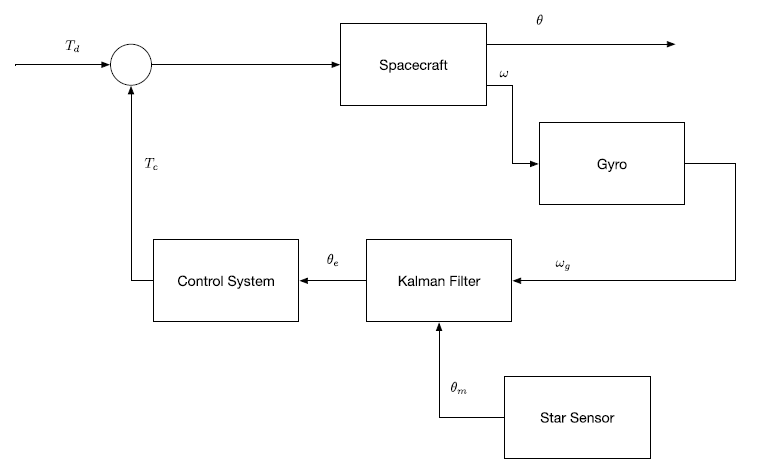

Los dos sistemas dinámicos que necesitan ser modelados en este ejemplo son el satélite y el gyro.

El modelo del satélite es un integrador doble:

$$I \ddot{\theta} = T_{c} + T_{d} $$

ó

$$\dot{\theta} = \omega$$

$$I \dot{\omega} = T_{c} + T_{d}$$

donde $\theta$ es el ángulo real y $\omega$ es la velocidad angular real, $I$ es la inercia, $T_{c}$ es el torque de control y $T_{d}$ es el torque pertubador.

Por otro lado, el modelo del gyro es un integrador simple:

$$\dot{\theta}_{g} = \omega + b + v_{\theta}$$

$$\dot{b} = v_{b}$$

donde $\theta_{g}$ es la integral de la velocidad angular verdadera  $\omega$ más el sesgo $b$. El sesgo se obtiene del ruido blanco, es decir que es un proceso random-walk. $v_{b}$ el la entrada de ruido del sesgo y $v_{\theta}$ es el ruido blanco del ángulo.


# Sistema de Control

El sistema de control es un sistema de proporcional-derivativo (PD), y en tiempo discreto está dado por la siguiente expresión:

$$ T_{C}[k] = -K_{f} \left( \theta_{e}[k] + \tau_{r} \left(\dfrac{\theta_{e}[k] - \theta_{e}[k - 1]}{\tau} \right) \right) $$
donde $K_{f}$ es la ganancia directa (Forward gain), $\tau_{r}$ es la constante de tiempo de amortiguamiento de la velocidad, $\tau$ es el paso del controlador y $k$ indica la muestra. Si se escribe el sistema de lazo cerrado continuo en el plano **s** obtenemos la siguiente ecuación de 2do orden:

$$ Is^{2} + K_{f} \tau_{r} s + K_{f} = 0 $$

Luego, se pueden igualar las ganancias con la frecuencia natural sin amortiguamiento y la relación de amortiguamiento, es decir:

$$ K_{f} = \omega_{n}^{2}I $$

$$ \tau_{r} = \dfrac{2 \zeta \omega_{n} I}{K_{f}} $$
donde $\omega_{n}$ es la frecuencia natural sin amortiguamiento y $\zeta$ es la relación de amortiguamiento.



# Filtro de Kalman

El filtro de Kalman tiene dos partes, la propagación del estado y la incorporación de la medición. El modelo del gyro en la forma de espacio-estado es:

$$ x_{k} = a x_{k-1} + b \omega_{k-1} $$

$$ \gamma = h x $$
donde $x$ es el vector de estado del filtro de Kalman, $h$ es la matriz de medición y $a$ es la matriz de transición de estado. Este implementa un paso temporal para el estado, transicionandolo desde el estado $k -1$ a aquel para $k$. Luego, expandiendo las matrices, tenemos:

$$  \begin{bmatrix} \theta_{g} \\ b \end{bmatrix}_{k} = \begin{bmatrix} 0 & \Delta t \\ 0 & 0 \end{bmatrix} \begin{bmatrix} \theta_{g} \\ b \end{bmatrix}_{k-1} + \begin{bmatrix} \Delta t \\ 0 \end{bmatrix} \omega_{k-1}$$

$$ \gamma = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} \theta_{g} \\ b \end{bmatrix} $$

El vector de estado está compuesto por el ángulo $\theta_{g}$ y el sesgo $b$. La ecuaciones muestran que la velocidad angular verdadera y el sesgo causan un cambio de estado.

Por otro lado, el paso de incorporación de la medición del filtro de Kalman es:

$$ k = \dfrac{p h^{T}}{h p h^{T} + r} $$

$$ x_{e} = k(\gamma - h x_{e}) $$

$$ p = (E - k h) p $$
donde $E$ es una matriz identidad de $2 \times 2$, $p$ es la matriz de covarianza, $r$ es la medición de la matriz de covarianzay $h$ es la matriz de medición.

Luego, el paso de propagación es:

$$ x_{e}[k] = a x_{e}[k] + b \left( \dfrac{\theta_{i}[k] - \theta_{i}[k-1]}{\Delta t} \right) $$

$$ p = a p a^{T} + q $$
donde $a$ es la matriz de transición de estado, $q$ es la matriz de covarianza del modelo y $\Delta t$ es el paso temporal. La matriz de covarianza del modelo es un aproximación de ruido blanco Gaussiano a todas las incertidumbres del modelo, incluyendo las entradas sin modelar.

Un punto importante es que la covarianza sigue un camino predeterminado por la covarianza medida, el modelo de covarianza y la covarianza inicial. Esencialmente, este es un filtro que alcanzará valores de estados estacionarios y se mantendrá allí por siempre.

# Ejemplo: Simulación de un eje de un satélite con rueda de reacción

El siguiente código corresponde a la obtención de la respuesta del sistema de un solo eje a una entrada escalón  cuando hay un segundo modo. El sistema tiene un modo oscilatorio y un modo de cuerpo rígido.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [ ]:
# Parámetros del modelo dinámico

tD = 1e-4 # Torque de perturbación en Nm
wJ = 0.6
zetaJ = 0.1
inertiaJ = 0.001
k = inertiaJ * wJ**2
c = 2 * zetaJ * wJ * inertiaJ
dRHS = {
    'inertia': 1,
    'tC': 0,
    'tD': tD,
    'sigTheta': 0.00001,
    'sigB': 0.0001,
    'inertiaJ': inertiaJ,
    'k': k,
    'c': c
}
sigM = 0.01 # Ruido de medición

In [ ]:
# %% Diseño del controlador
zeta = 1.0
wN = 0.1
kF = wN**2 * dRHS['inertia']
tauR = 2 * zeta * wN * dRHS['inertia'] / kF
thetaOLD = 0

In [ ]:
# %% Cálculo de los valores propios
gamma = dRHS['inertiaJ'] * dRHS['inertia'] / (dRHS['inertiaJ'] + dRHS['inertia'])
a = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, dRHS['k'] / dRHS['inertia'], 0, dRHS['c'] / dRHS['inertia']],
    [0, -dRHS['k'] / gamma, 0, -dRHS['c'] / gamma]
])
print("Eigenvalues:", np.linalg.eigvals(a))

Eigenvalues: [ 0.     +0.j          0.     +0.j         -0.06006+0.59728787j
 -0.06006-0.59728787j]


In [ ]:
# %% Filtro de Kalman
dT = 0.01
p = np.diag([0.001, 0.0001]) # Covarianza inicial
q = 0.01 * p # Covarianza del modelo
dkF = {
    'p': p,
    'q': q,
    'r': sigM**2,
    'thetaE': 0,
    'xE': np.array([0, 0]),
    'a': np.array([[0, dT], [0, 0]]),
    'b': np.array([dT, 0]),
    'h': np.array([1, 0]),
    'thetaGO1d': 0,
    'dT': dT
}

In [ ]:
# %% Configuración de la simulación
n = 1000000
xP = np.zeros((9, n))
x = np.array([0, 0, 0, 0.1, 0, 0]) # [ángulo, velocidad, ángulo del gyro, sesgo, psi, psiDot]

def rhs(x,d):
  omega = x[1]
  b = x[3]
  psi = x[4]
  psiDot = x[5]

  tJ = -d['k'] * psi - d['c'] * psiDot
  omegaDot = (d['tC'] + d['tD'] - tJ) / d['inertia']

  xDot = np.array([
      omega,
      omegaDot,
      omega + b +d['sigTheta'] * np.random.randn(),
      d['sigB'] * np.random.randn(),
      psiDot,
      tJ / d['inertiaJ'] - omegaDot
  ])

  return xDot

def Kalman_filter(thetaG, y, d):
  omega = (thetaG - d['thetaGO1d']) / d['dT']
  d['thetaGO1d'] = thetaG

  # Propagación del estado
  d['xE'] = d['a'].dot(d['xE']) + d['b'] * omega
  d['p'] = d['a'].dot(d['p']).dot(d['a'].T) + d['q']

  # Incorporación de la medición
  k = d['p'].dot(d['h'].T) / (d['h'].dot(d['p']).dot(d['h'].T) + d['r'])
  d['xE'] += k * (y - d['h'].dot(d['xE']))
  d['p'] = (np.eye(2) - np.outer(k, d['h'])).dot(d['p'])
  d['thetaE'] = d['xE'][0]

  return d

def rk4(f, x, dt, params):
  k1 = f(x, params)
  k2 = f(x + 0.5 * dt * k1, params)
  k3 = f(x + 0.5 * dt * k2, params)
  k4 = f(x + dt * k3, params)

  return x + (dt/6) * (k1 + 2 * k2 + 2 * k3 + k4)

for k in range(n):
  thetaM = x[0] + sigM * np.random.randn() # Medición
  thetaG = x[2] # Ángulo del gyro
  dkF = Kalman_filter(thetaG, thetaM, dkF)
  dRHS['tC'] = -kF * (dkF['thetaE'] + tauR * (dkF['thetaE'] - thetaOLD) / dT)
  thetaOLD = dkF['thetaE']
  xP[:, k] = np.concatenate((x, [dRHS['tC'], dkF['thetaE'], thetaM]))
  x = rk4(rhs, x, dT, dRHS)


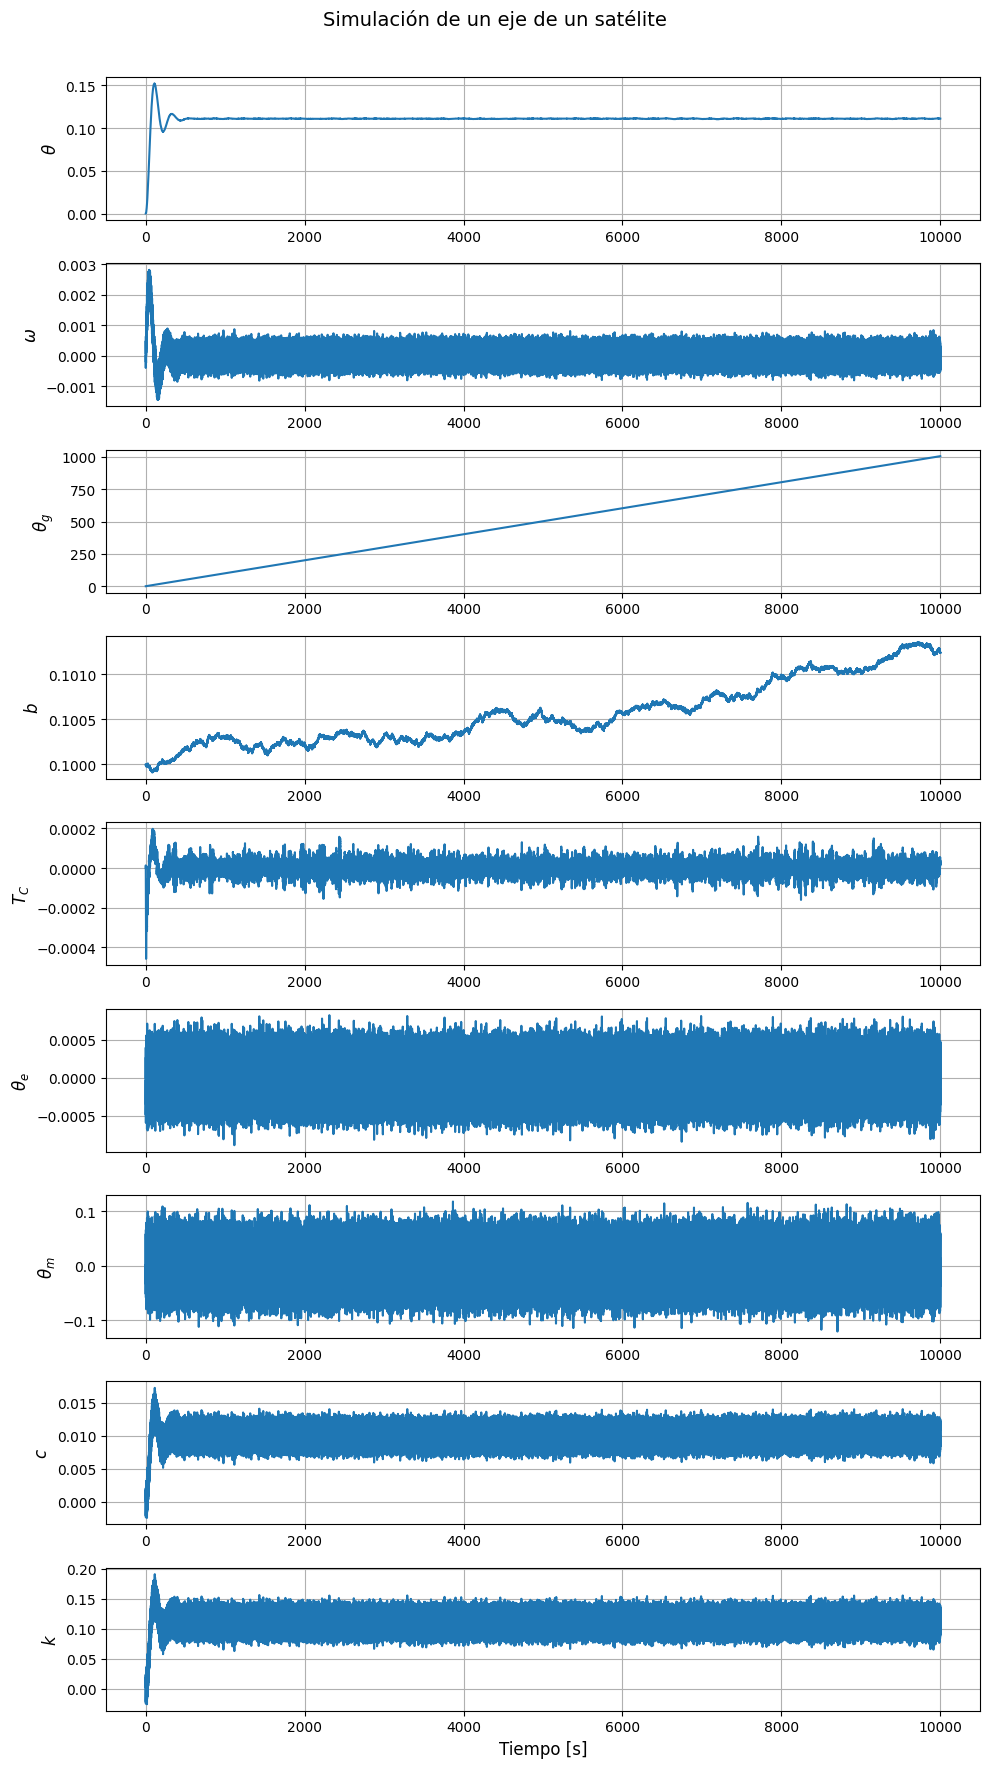

In [ ]:
# %% Gráficos
def time_history(t, xP, yL, title_text):
  n_vars = xP.shape[0]
  plt.figure(figsize=(10, 2 * n_vars))
  for i in range(n_vars):
    plt.subplot(n_vars, 1, i + 1)
    plt.plot(t, xP[i, :], linewidth=1.5)
    plt.ylabel(yL[i], fontsize=12)
    plt.grid()
  plt.xlabel('Tiempo [s]', fontsize=12)
  plt.suptitle(title_text, fontsize=14)
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

t = np.arange(0, n * dT, dT)
yL = [
      '$\\theta$', '$\\omega$', '$\\theta_g$', '$b$', '$T_C$',
      '$\\theta_e$', '$\\theta_m$', '$c$', '$k$'
  ]

time_history(t, xP, yL, 'Simulación de un eje de un satélite')